In [12]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
#from osgeo import gdal
import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
import pyproj
from pyproj import Proj
from shapely.ops import transform
import xarray as xr
#import geoviews as gv
#from cartopy import crs
import hvplot.xarray
import holoviews as hv
import boto3
from rasterio.session import AWSSession

# Section 1: Navigating the CMR-STAC API

## Set GDAL Configuration Options

In [13]:
r.packages.urllib3.disable_warnings()

def get_temp_creds():
    temp_creds_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
    return r.get(temp_creds_url, verify=False).json()

temp_creds_req = get_temp_creds()
#temp_creds_req

session = boto3.Session(aws_access_key_id=temp_creds_req['accessKeyId'], 
                        aws_secret_access_key=temp_creds_req['secretAccessKey'],
                        aws_session_token=temp_creds_req['sessionToken'],
                        region_name='us-west-2')

rio_env = rio.Env(AWSSession(session),
                  GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='tif',
                  GDAL_HTTP_UNSAFESSL='YES',
                  VSI_CACHE=True,
                  region_name='us-west-2',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

## 1. STAC API: Endpoint that enables the querying of STAC items

In [14]:
stac = 'https://cmr.earthdata.nasa.gov/stac/' # CMR-STAC API Endpoint
r.packages.urllib3.disable_warnings()  # Disable SSL warnings
stac_response = r.get(stac, verify=False).json() # Call the STAC API endpoint
for s in stac_response: print(s)

print(f"You are now using the {stac_response['id']} API (STAC Version: {stac_response['stac_version']}). {stac_response['description']}")
print(f"There are {len(stac_response['links'])} STAC catalogs available in CMR.")

id
title
stac_version
type
description
links
You are now using the stac API (STAC Version: 1.0.0). This is the landing page for CMR-STAC. Each provider link contains a STAC endpoint.
There are 59 STAC catalogs available in CMR.


## 2. STAC Catalog: Contains a JSON file of links that organize all of the collections available

In [15]:
stac_lp = [s for s in stac_response['links'] if 'LP' in s['title']]  # Search for only LP-specific catalogs

# LPCLOUD is the STAC catalog we will be using and exploring today
lp_cloud = r.get([s for s in stac_lp if s['title'] == 'LPCLOUD'][0]['href'], verify=False).json()
for l in lp_cloud: print(f"{l}: {lp_cloud[l]}")

# Print the links contained in the LP CLOUD STAC Catalog
lp_links = lp_cloud['links']
for l in lp_links: 
    try: 
        print(f"{l['href']} is the {l['title']}")
    except:
        print(f"{l['href']}")

id: LPCLOUD
title: LPCLOUD
description: Root catalog for LPCLOUD
type: Catalog
stac_version: 1.0.0
links: [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'title': 'Provider catalog', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'Root catalog', 'type': 'application/json'}, {'rel': 'collections', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'Provider Collections', 'type': 'application/json'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'GET'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'POST'}, {'rel': 'conformance', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance', 'title': 'Conformance Classes', 'type': 'application/geo+json'}, {'rel': 'ser

## 3. STAC Collection: Extension of STAC Catalog containing additional information that describe the STAC items in that collection

In [16]:
# Get a response form the LPCLOUD collection and print the information included in the response
lp_collections = [l['href'] for l in lp_links if l['rel'] == 'collections'][0]  # Set collections endpoint to variable
print(lp_collections)
collections_response = r.get("https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/?page=2", verify=False).json()                        # Call collections endpoint
print(collections_response)
print(f"This collection contains {collections_response['description']} ({len(collections_response['collections'])} available)")

collections = collections_response['collections']
print("\n")

# Search available version 2 collections for HLS and print them out
hls_collections = [c for c in collections if 'HLS' in c['id'] and 'v2' in c['id']]
#print(hls_collections)
for h in hls_collections: 
    print(f"{h['title']} has an ID (shortname) of: {h['id']}")

# Explore the attributes contained in the HLSS30 collection
s30 = [h for h in hls_collections if 'HLSS30' in h['id']][0]    # Grab HLSS30 collection

for s in s30['extent']:                                         # Check out the extent of this collection
    print(f"{s}: {s30['extent'][s]}")

print(f"HLS S30 Start Date is: {s30['extent']['temporal']['interval'][0][0]}")

l30 = [h for h in hls_collections if 'HLSL30' in h['id'] and 'v2.0' in h['id']][0]     # Grab HLSL30 collection

for l in l30['extent']:                                                                # Check out the extent of this collection
    print(f"{l}: {l30['extent'][l]}")

https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections
{'id': 'LPCLOUD', 'stac_version': '1.0.0', 'description': 'All collections provided by LPCLOUD', 'license': 'not-provided', 'type': 'Catalog', 'links': [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'All collections provided by LPCLOUD', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'CMR-STAC Root', 'type': 'application/json'}, {'rel': 'prev', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/?page=1'}, {'rel': 'next', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/?page=3'}], 'collections': [{'id': 'ECO_L2_LSTE.v002', 'stac_version': '1.0.0', 'license': 'not-provided', 'title': 'ECOSTRESS Swath Land Surface Temperature and Emissivity Instantaneous L2 Global 70 m V002', 'type': 'Collection', 'description': 'The ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station (ECOSTRESS) mission 

## 4. STAC Item: Represents data and metadata assets that are spatiotempporally coincident

In [17]:
# Below, go through all links in the collection and return the link containing the items endpoint
s30_items = [s['href'] for s in s30['links'] if s['rel'] == 'items'][0]    # Set items endpoint to variable
s30_items

s30_items_response = r.get(f"{s30_items}", verify=False).json()    # Call items endpoint
s30_item = s30_items_response['features'][0]         # select first item (10 items returned by default)
s30_item

# Print metadata attributes from this observation
print(f"The ID for this item is: {s30_item['id']}")
print(f"It was acquired on: {s30_item['properties']['datetime']}")
print(f"over: {s30_item['bbox']} (Lower Left, Upper Right corner coordinates)")
print(f"It contains {len(s30_item['assets'])} assets")
print(f"and is {s30_item['properties']['eo:cloud_cover']}% cloudy.")

for i, s in enumerate(s30_items_response['features']):
    print(f"Item at index {i} is {s['properties']['eo:cloud_cover']}% cloudy.")

item_index = 0    # Indexing starts at 0 in Python, so here select the eighth item in the list at index 0

s30_item = s30_items_response['features'][item_index]    # Grab the next item in the list

print(f"The ID for this item is: {s30_item['id']}")
print(f"It was acquired on: {s30_item['properties']['datetime']}")
print(f"over: {s30_item['bbox']} (Lower Left, Upper Right corner coordinates)")
print(f"It contains {len(s30_item['assets'])} assets")
print(f"and is {s30_item['properties']['eo:cloud_cover']}% cloudy.")

print("The following assets are available for download:")
for a in s30_item['assets']: print(a)

s30_item['assets']['browse']

image = io.imread(s30_item['assets']['browse']['href'])    # Load jpg browse image into memory

# Basic plot of the image
#plt.figure(figsize=(10,10))              
#plt.imshow(image)
#plt.show()

The ID for this item is: HLS.S30.T55JGM.2015332T001732.v2.0
It was acquired on: 2015-11-28T00:17:27.450Z
over: [148.986215, -25.317703, 148.990385, -25.302755] (Lower Left, Upper Right corner coordinates)
It contains 20 assets
and is 100% cloudy.
Item at index 0 is 100% cloudy.
Item at index 1 is 5% cloudy.
Item at index 2 is 1% cloudy.
Item at index 3 is 2% cloudy.
Item at index 4 is 100% cloudy.
Item at index 5 is 0% cloudy.
Item at index 6 is 100% cloudy.
Item at index 7 is 20% cloudy.
Item at index 8 is 1% cloudy.
Item at index 9 is 0% cloudy.
The ID for this item is: HLS.S30.T55JGM.2015332T001732.v2.0
It was acquired on: 2015-11-28T00:17:27.450Z
over: [148.986215, -25.317703, 148.990385, -25.302755] (Lower Left, Upper Right corner coordinates)
It contains 20 assets
and is 100% cloudy.
The following assets are available for download:
B08
Fmask
B11
VZA
B02
SAA
B03
B06
VAA
SZA
B07
B8A
B01
B10
B04
B12
B09
B05
browse
metadata


# Section 2: CMR-STAC API: Searching for Items

In [18]:
# Remove unnecessary variables
del s30_items, s30_items_response, stac_lp, stac_response, l30
del a, collections, collections_response, h, hls_collections, l, lp_cloud, lp_collections, s, s30, s30_item

print(lp_links)
lp_search = [l['href'] for l in lp_links if l['rel'] == 'search'][0]    # Define the search endpoint
print(lp_search)

# Set up a dictionary that will be used to POST requests to the search endpoint
params = {}

search_response = r.post(lp_search, json=params, verify=False).json()    # Send POST request to retrieve items
print(f"{len(search_response['features'])} items found!")

lim = 100
params['limit'] = lim  # Add in a limit parameter to retrieve 100 items at a time.
print(params)

search_response = r.post(lp_search, json=params, verify=False).json()  # send POST request to retrieve first 100 items in the STAC collection

print(f"{len(search_response['features'])} items found!")

[{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'title': 'Provider catalog', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'Root catalog', 'type': 'application/json'}, {'rel': 'collections', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'Provider Collections', 'type': 'application/json'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'GET'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'POST'}, {'rel': 'conformance', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/conformance', 'title': 'Conformance Classes', 'type': 'application/geo+json'}, {'rel': 'service-desc', 'href': 'https://api.stacspec.org/v1.0.0-beta.1/openapi.yaml', 'title': 'OpenAPI Doc', 'type':

In [19]:
# Bring in the farm field region of interest
field = gp.read_file('Field_Boundary.geojson')
field

fieldShape = field['geometry'][0] # Define the geometry as a shapely polygon
fieldShape

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
#base = gv.tile_sources.EsriImagery.opts(width=500, height=500)
#farmField = gv.Polygons(fieldShape).opts(line_color='yellow', color=None)

#base * farmField

bbox = f'{fieldShape.bounds[0]},{fieldShape.bounds[1]},{fieldShape.bounds[2]},{fieldShape.bounds[3]}'    # Defined from ROI bounds
params['bbox'] = bbox                                                                                    # Add ROI to params
print(params)

search_response = r.post(lp_search, json=params, verify=False).json()    # Send POST request with bbox included
print(f"{len(search_response['features'])} items found!")
print(search_response)

date_time = "2021-07-01T00:00:00Z/2021-08-31T23:59:59Z"    # Define start time period / end time period
params['datetime'] = date_time
print(params)

search_response = r.post(lp_search, json=params, verify=False).json()    # Send POST request with datetime included
print(f"{len(search_response['features'])} items found!")

s30_id = "HLSS30.v2.0"
params["collections"] = [s30_id]

# Search for the HLSS30 items of interest:
s30_items = r.post(lp_search, json=params, verify=False).json()['features']  # Send POST request with collection included
len(s30_items)

l30_id = "HLSL30.v2.0"
params["collections"].append(l30_id)
print(params)

# Search for the HLSS30 and HLSL30 items of interest:
hls_items = r.post(lp_search, json=params, verify=False).json()['features']    # Send POST request with S30 and L30 collections included
print(len(hls_items))
print(hls_items)

del bbox, date_time, field, lim, lp_links, lp_search, search_response, s30_items    # Remove

{'limit': 100, 'bbox': '-122.0622682571411,39.897234301806,-122.04918980598451,39.91309383703065'}
100 items found!
{'type': 'FeatureCollection', 'stac_version': '1.0.0', 'numberMatched': 1093517, 'numberReturned': 100, 'features': [{'type': 'Feature', 'id': 'v_1_5_1980_gridmet_historical_monthly', 'stac_version': '1.0.0', 'stac_extensions': [], 'collection': 'WaterBalance_Monthly_Historical_GRIDMET.v1.5', 'geometry': {'type': 'Polygon', 'coordinates': [[[-131.70607, 21.115301], [-60.530453, 21.115301], [-60.530453, 55.457306], [-131.70607, 55.457306], [-131.70607, 21.115301]]]}, 'bbox': [-131.70607, 21.115301, -60.530453, 55.457306], 'links': [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/WaterBalance_Monthly_Historical_GRIDMET.v1.5/items/v_1_5_1980_gridmet_historical_monthly'}, {'rel': 'parent', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/WaterBalance_Monthly_Historical_GRIDMET.v1.5'}, {'rel': 'collection', 'href': 'https://cmr.

# Section 3: Extracting HLS COGs from the Cloud

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B02.tif


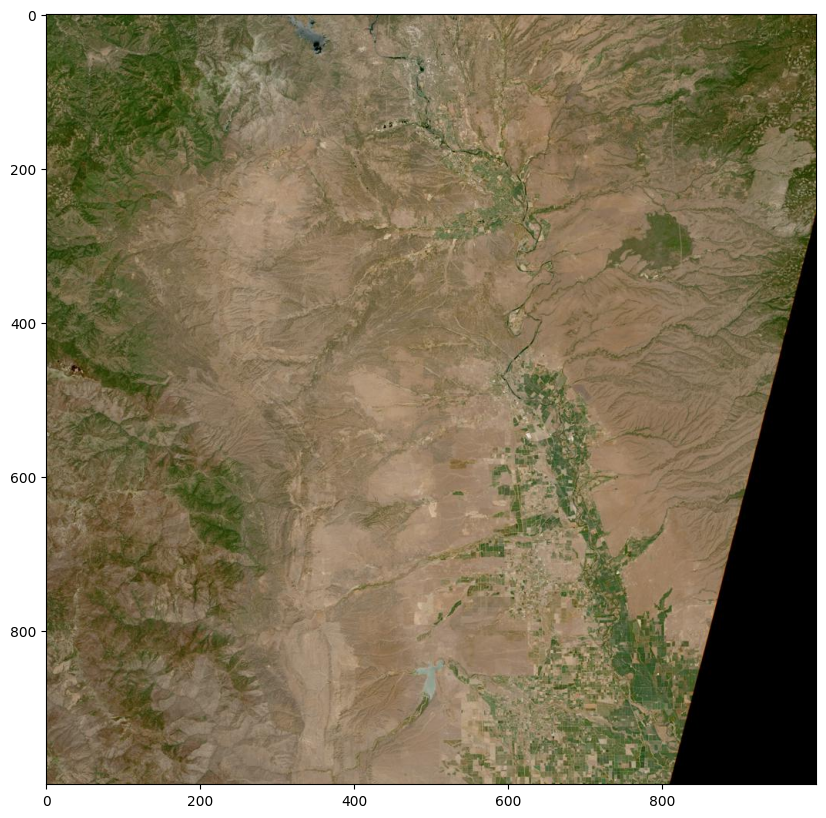

In [20]:
# Subset by Band

h = hls_items[0]

evi_band_links = []

# Define which HLS product is being accessed
if h['assets']['browse']['href'].split('/')[4] == 'HLSS30.015':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in h['assets']: 
    if any(b == a for b in evi_bands):
        evi_band_links.append(h['assets'][a]['href'])
for e in evi_band_links: print(e)

image = io.imread(h['assets']['browse']['href'])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

del image # Remove the browse image


# Section 4: Extracting HLS COGs from the 

## Subset by Band

In [21]:
h = hls_items[0]
h['assets']

{'B05': {'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif',
  'title': 'Download HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif'},
 'B10': {'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B10.tif',
  'title': 'Download HLS.S30.T10TEK.2021182T185921.v2.0.B10.tif'},
 'B04': {'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif',
  'title': 'Download HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif'},
 'B08': {'href': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B08.tif',
  'title': 'Download HLS.S30.T10TEK.2021182T185921.v2.0.B08.tif'},
 'Fmask': {'href': 'https://data.lpdaac.earthdat

In [22]:
evi_band_links = []

# Define which HLS product is being accessed
if h['assets']['browse']['href'].split('/')[4] == 'HLSS30.015':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30 (Sentinel 2)
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30 (Landsat 8)

# Subset the assets in the item down to only the desired bands
for a in h['assets']: 
    if any(b == a for b in evi_bands):
        evi_band_links.append(h['assets'][a]['href'])
for e in evi_band_links: print(e)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B02.tif


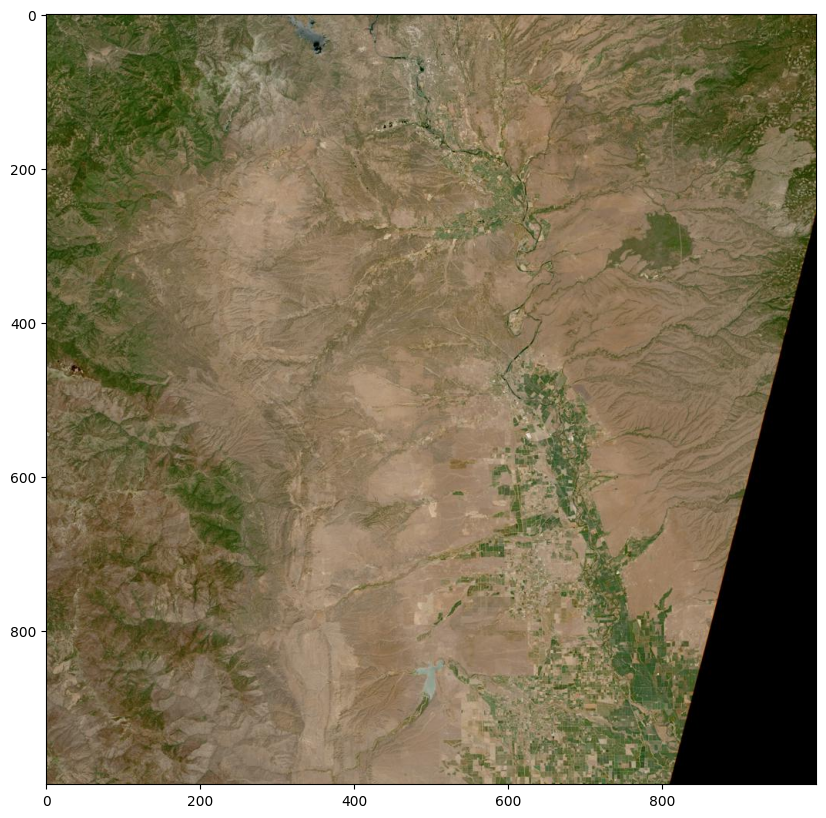

In [23]:
image = io.imread(h['assets']['browse']['href'])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

## Load a Spatially Subset HLS COG into Memory

In [24]:
# AUTHENTICATION CONFIGURATION
from netrc import netrc
from subprocess import Popen, DEVNULL, STDOUT
from getpass import getpass
from sys import platform

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

# Determine if netrc file exists, and if it includes NASA Earthdata Login Credentials
if 'win' in platform:
    nrc = '_netrc'
else:
    nrc = '.netrc'
try:
    netrcDir = os.path.expanduser(f"~/{nrc}")
    netrc(netrcDir).authenticators(urs)[0]
    del netrcDir

# If not, create a netrc file and prompt user for NASA Earthdata Login Username/Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")

    # Windows OS won't read the netrc unless this is set
    Popen(f'setx HOME {homeDir}', shell=True, stdout=DEVNULL);

    if nrc == '.netrc':
        Popen(f'touch {homeDir + os.sep}{nrc} | chmod og-rw {homeDir + os.sep}{nrc}', shell=True, stdout=DEVNULL, stderr=STDOUT);

    # Unable to use touch/chmod on Windows OS
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen(f'echo machine {urs} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo login {getpass(prompt=prompts[0])} >> {homeDir + os.sep}{nrc}', shell=True)
    Popen(f'echo password {getpass(prompt=prompts[1])} >> {homeDir + os.sep}{nrc}', shell=True)
    del homeDir
del urs, prompts

In [27]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
for e in evi_band_links:
    print(e)
    print(e.rsplit('.', 2)[-2])
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rio.open(e)
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rio.open(e)
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif
B05
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B04.tif
B04
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.Fmask.tif
Fmask
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B02.tif
B02
The COGs have been loaded into memory!


In [28]:
geo_CRS = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)  # Source coordinate system of the ROI
print(nir)
utm = pyproj.Proj(nir.crs)                                                  # Destination coordinate system
project = pyproj.Transformer.from_proj(geo_CRS, utm)                        # Set up the transformation
fsUTM = transform(project.transform, fieldShape)                            # Apply reprojection

<open DatasetReader name='https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021182T185921.v2.0/HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif' mode='r'>


[[[-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  ...
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]]]
[[-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 ...
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]
 [-9999 -9999 -9999 ... -9999 -9999 -9999]]


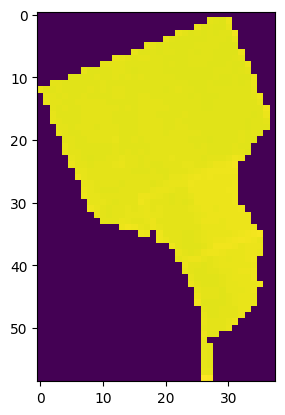

In [29]:
nir_array, nir_transform = rio.mask.mask(nir, [fsUTM], crop=True)  # Extract the data for the ROI and clip to that bbox
print(nir_array)
print(nir_array[0])
plt.imshow(nir_array[0]);  # Quick visual to assure that it worked

In [25]:
red_array, _ = rio.mask.mask(red,[fsUTM],crop=True)
blue_array, _ = rio.mask.mask(blue,[fsUTM],crop=True)
print('Data is loaded into memory!')

Data is loaded into memory!


In [28]:
del a, e, evi_band_links, evi_bands  # Remove variables that are no longer needed

# Section 5: Processing HLS Data ------- See if it gets to here

## Apply Scale Factor and Calculate EVI

In [29]:
nir.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, 499980.0,
        0.0, -30.0, 4500000.0)}

In [30]:
# Grab scale factor from metadata and apply to each band
nir_scaled = nir_array[0] * nir.scales[0]
red_scaled = red_array[0] * red.scales[0]
blue_scaled = blue_array[0] * blue.scales[0]

In [31]:
# Set all nodata values to nan
nir_scaled[nir_array[0]==nir.nodata] = np.nan 
red_scaled[red_array[0]==red.nodata] = np.nan 
blue_scaled[blue_array[0]==blue.nodata] = np.nan 

In [32]:
def evi(red, blue, nir):
      return 2.5 * (nir - red) / (nir + 6.0 * red - 7.5 * blue + 1.0) 

In [33]:
evi_scaled = evi(red_scaled, blue_scaled, nir_scaled) # Generate EVI array

In [34]:
eviDate = h['properties']['datetime'].split('T')[0]  # Set the observation date to a variable

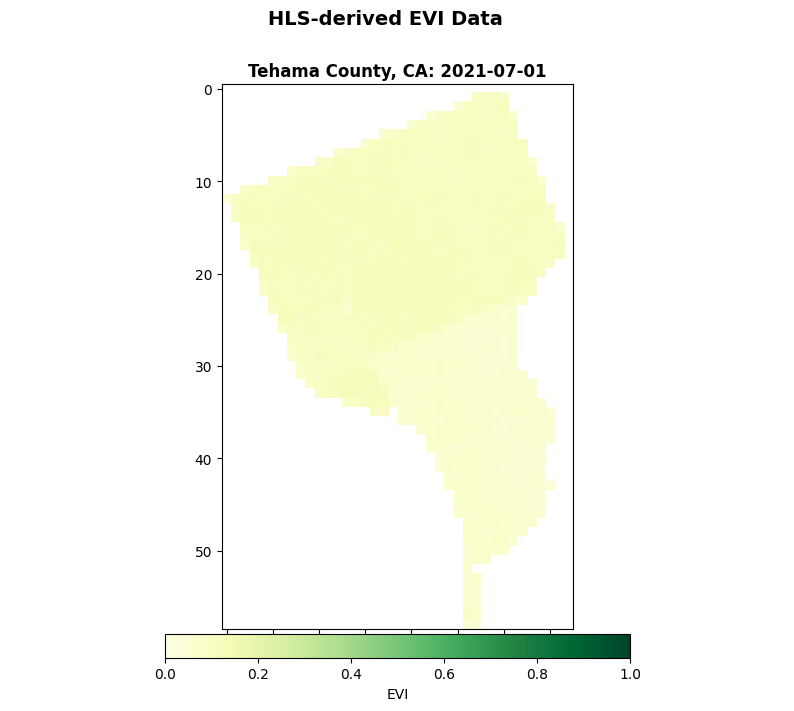

In [35]:
# Ignore matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
plt.axis('off')                         # Remove the axes' values

fig.suptitle('HLS-derived EVI Data', fontsize=14, fontweight='bold')  # Make a figure title
ax = fig.add_subplot(111)                                                                  # Make a subplot
ax.set_title(f'Tehama County, CA: {eviDate}', fontsize=12, fontweight='bold')              # Add figure subtitle
ax1 = plt.gca()                                                                            # Get current axes

# Plot the array, using a colormap and setting a custom linear stretch 
im = plt.imshow(evi_scaled, vmin=0, vmax=1, cmap='YlGn');

# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.047, pad=0.009, label='EVI', shrink=0.6).outline.set_visible(True)

## Quality Filtering

In [36]:
fmask_array, _ = rio.mask.mask(fmask, [fsUTM], crop=True)  # Load in the Quality data

In [37]:
bitword_order = (1, 1, 1, 1, 1, 1, 2)  # set the number of bits per bitword
num_bitwords = len(bitword_order)      # Define the number of bitwords based on your input above
total_bits = sum(bitword_order)        # Should be 8, 16, or 32 depending on datatype

In [38]:
qVals = list(np.unique(fmask_array))  # Create a list of unique values that need to be converted to binary and decoded
all_bits = list()
goodQuality = []
for v in qVals:
    all_bits = []
    bits = total_bits
    i = 0

    # Convert to binary based on the values and # of bits defined above:
    bit_val = format(v, 'b').zfill(bits)
    print('\n' + str(v) + ' = ' + str(bit_val))
    all_bits.append(str(v) + ' = ' + str(bit_val))

    # Go through & split out the values for each bit word based on input above:
    for b in bitword_order:
        prev_bit = bits
        bits = bits - b
        i = i + 1
        if i == 1:
            bitword = bit_val[bits:]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
        elif i == num_bitwords:
            bitword = bit_val[:prev_bit]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
        else:
            bitword = bit_val[bits:prev_bit]
            print(' Bit Word ' + str(i) + ': ' + str(bitword))
            all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))

    # 2, 4, 5, 6 are the bits used. All 4 should = 0 if no clouds, cloud shadows were present, and pixel is not snow/ice/water
    if int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
    int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1]) == 0:
        goodQuality.append(v)


64 = 01000000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

128 = 10000000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 10

255 = 11111111
 Bit Word 1: 1
 Bit Word 2: 1
 Bit Word 3: 1
 Bit Word 4: 1
 Bit Word 5: 1
 Bit Word 6: 1
 Bit Word 7: 11


In [39]:
goodQuality

[64, 128]

In [40]:
evi_band = np.ma.MaskedArray(evi_scaled, np.in1d(fmask_array, goodQuality, invert=True))  # Apply QA mask to the EVI data
evi_band = np.ma.filled(evi_band, np.nan)  

## Export to COG

In [41]:
originalName = nir.name.rsplit('/', 1)[-1]  # Grab the original granule name
originalName

'HLS.S30.T10TEK.2021182T185921.v2.0.B05.tif'

In [42]:
outName = f"{originalName.split('.B')[0]}_EVI.tif"  # Generate output name from the original filename
tempName = 'temp.tif'                               # Set up temp file
outName

'HLS.S30.T10TEK.2021182T185921.v2.0_EVI.tif'

In [43]:
# Create output GeoTIFF with overviews
evi_tif = rio.open(tempName, 'w', driver='GTiff', height=evi_band.shape[0], width=evi_band.shape[1], count=1,
                   dtype=str(evi_band.dtype), crs=nir.crs, transform=nir_transform)

evi_tif.write(evi_band, 1)                                    # Write the EVI band to the newly created GeoTIFF
evi_tif.build_overviews([2, 4, 8], Resampling.average)        # Calculate overviews
evi_tif.update_tags(ns='rio_overview', resampling='average')  # Update tags

# Copy the profile, add tiling and compression
kwds = evi_tif.profile
kwds['tiled'] = True
kwds['compress'] = 'LZW'

In [44]:
evi_tif.overviews(1)  # Print overviews

[2, 4, 8]

In [45]:
 
evi_tif.close()  # Close file

In [47]:
# Open temp file and export as valid cog
with rio.open(tempName, 'r+') as src:
    copy(src, outName, copy_src_overviews=True, **kwds)
src.close()
os.remove(tempName)

CPLE_AppDefinedError: _TIFFVSetField:HLS.S30.T10TEK.2021182T185921.v2.0_EVI.tif: Bad value 26 for "TileLength" tag

In [ ]:
src.close(), nir.close(), red.close(), fmask.close(), blue.close()
del nir_array, red_array, blue_array, red_scaled, blue_scaled, nir_scaled, i, originalName, outName, prev_bit, qVals, v
del all_bits, b, bit_val, bits, bitword, eviDate, evi_band, evi_scaled, fmask_array, goodQuality, h

# Section 6: Automation

In [ ]:
len(hls_items)

In [ ]:
# Now put it all together and loop through each of the files, visualize, calculate statistics on EVI, and export
for j, h in enumerate(hls_items):
    outName = h['assets']['browse']['href'].split('/')[-1].replace('.jpg', '_EVI.tif')

    # Check if file already exists in output directory, if yes--skip that file and move to the next observation
    if os.path.exists(outName):
        print(f"{outName} has already been processed and is available in this directory, moving to next file.")
        continue
    try:
        evi_band_links = []
        if h['assets']['browse']['href'].split('/')[4] == 'HLSS30.015':
            evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
        else:
            evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
        for a in h['assets']: 
            if any(b == a for b in evi_bands):
                evi_band_links.append(h['assets'][a]['href'])

        # Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
        for e in evi_band_links:
            if e.rsplit('.', 2)[-2] == evi_bands[0]: # NIR index
                nir = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[1]: # red index
                red = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[2]: # blue index
                blue = rio.open(e)
            elif e.rsplit('.', 2)[-2] == evi_bands[3]: # fmask index
                fmask = rio.open(e)

        # load data and scale
        nir_array,nir_transform = rio.mask.mask(nir,[fsUTM],crop=True)
        red_array, _ = rio.mask.mask(red,[fsUTM],crop=True)
        blue_array, _ = rio.mask.mask(blue,[fsUTM],crop=True)
        nir_scaled = nir_array[0] * nir.scales[0]
        red_scaled = red_array[0] * red.scales[0]
        blue_scaled = blue_array[0] * blue.scales[0]
        nir_scaled[nir_array[0]==nir.nodata] = np.nan 
        red_scaled[red_array[0]==red.nodata] = np.nan 
        blue_scaled[blue_array[0]==blue.nodata] = np.nan 

        # Generate EVI
        evi_scaled = evi(red_scaled, blue_scaled, nir_scaled)

        # Quality Filter the data
        fmask_array, _ = rio.mask.mask(fmask,[fsUTM],crop=True)
        qVals = list(np.unique(fmask_array))
        all_bits = list()
        goodQuality = []
        for v in qVals:
            all_bits = []
            bits = total_bits
            i = 0
            # Convert to binary based on the values and # of bits defined above:
            bit_val = format(v, 'b').zfill(bits)
            all_bits.append(str(v) + ' = ' + str(bit_val))

            # Go through & split out the values for each bit word based on input above:
            for b in bitword_order:
                prev_bit = bits
                bits = bits - b
                i = i + 1
                if i == 1:
                    bitword = bit_val[bits:]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
                elif i == num_bitwords:
                    bitword = bit_val[:prev_bit]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
                else:
                    bitword = bit_val[bits:prev_bit]
                    all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))

            # 2, 4, 5, 6 are the bits used. All should = 0 if no clouds, cloud shadows were present & pixel is not snow/ice/water
            if int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
            int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1]) == 0:
                goodQuality.append(v)
        evi_band = np.ma.MaskedArray(evi_scaled, np.in1d(fmask_array, goodQuality, invert=True))  # Apply QA mask to the EVI data
        evi_band = np.ma.filled(evi_band, np.nan)

        # Remove any observations that are entirely fill value
        if np.nansum(evi_band) == 0.0:
            print(f"File: {h['assets']['browse']['href'].split('/')[-1].rsplit('.', 1)[0]} ({h['id']}) was entirely fill values and will not be exported.")
            continue
        tempName = "temp.tif"
        # Create output GeoTIFF with overviews
        evi_tif = rio.open(tempName, 'w', driver='GTiff', height=evi_band.shape[0], width=evi_band.shape[1], count=1,
                           dtype=str(evi_band.dtype), crs=nir.crs, transform=nir_transform)
        evi_tif.write(evi_band, 1)
        evi_tif.build_overviews([2, 4, 8], Resampling.average)
        evi_tif.update_tags(ns='rio_overview', resampling='average')

        # Copy the profile, add tiling and compression
        kwds = evi_tif.profile
        kwds['tiled'] = True
        kwds['compress'] = 'LZW'
        evi_tif.close()

        # Open temp file and export as valid cog
        with rio.open(tempName, 'r+') as src:
            copy(src, outName, copy_src_overviews=True, **kwds)
        src.close(), os.remove(tempName);

    except:
        print(f"Unable to access file: {h['assets']['browse']['href'].split('/')[-1].rsplit('.', 1)[0]} ({h['id']})")
    print(f"Processing file {j+1} of {len(hls_items)}")

# Section 7: Stacking HLS Data

--- optional -> Section 6 already covers the COG export (what we need most)